In [3]:
import keras
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt


In [4]:
def convert_pixel_id_to_nla(pixel_id: np.ndarray, padding_value: int = -1) -> np.ndarray:
    nla = np.full((*pixel_id.shape, 4), padding_value, dtype=np.int32)
    valid_mask = pixel_id != padding_value

    chip_id = pixel_id // 2**16
    station = chip_id // 2**12
    layer = ((chip_id // 2**10) % 4) + 1
    phi = ((chip_id // 2**5) % 2**5) + 1
    z_prime = chip_id % 2**5

    z = np.where(layer == 3, z_prime - 7, np.where(layer == 4, z_prime - 6, z_prime))

    station_mask = (station == 0)
    valid_mask = valid_mask & station_mask

    nla[valid_mask, 0] = station[valid_mask]
    nla[valid_mask, 1] = layer[valid_mask]
    nla[valid_mask, 2] = phi[valid_mask]
    nla[valid_mask, 3] = z[valid_mask]

    return nla

def convert_nla_to_location(nla: np.ndarray, padding_value: int = -1) -> np.ndarray:
    location = np.full((*nla.shape[:-1], 3), padding_value, dtype=np.float64)
    valid_mask = ~(nla[:,:, ] == padding_value).any(axis=-1)
    layer = nla[:, : , 1]
    phi = nla[:, : , 2]
    z = nla[:, : , 3]
    #### Define the paramters of the detector layers
    r_layer_1 = 23.3
    r_layer_2 = 29.8
    r_layer_3 = 73.9
    r_layer_4 = 86.3
    length_layer_1 = 124.7
    length_layer_2 = 124.7
    length_layer_3 = 351.9
    length_layer_4 = 372.6
    nz_layer_1 = 6
    nz_layer_2 = 6
    nz_layer_3 = 17
    nz_layer_4 = 18

    nphi_layer_1 = 8
    nphi_layer_2 = 10
    nphi_layer_3 = 24
    nphi_layer_4 = 28

    #### Calculate the z-coordinate in the detector
    location[layer == 1, 2] = ((z[layer == 1])/ nz_layer_1 - 0.5 ) * length_layer_1
    location[layer == 2, 2] = ((z[layer == 2])/ nz_layer_2 - 0.5 ) * length_layer_2
    location[layer == 3, 2] = ((z[layer == 3])/ nz_layer_3 - 0.5 ) * length_layer_3
    location[layer == 4, 2] = ((z[layer == 4])/ nz_layer_4 - 0.5 ) * length_layer_4

    #### Calculate the x-coordinate in the detector
    location[layer == 1, 0] = r_layer_1 * np.cos((phi[layer == 1]) / nphi_layer_1 * 2 * np.pi)
    location[layer == 2, 0] = r_layer_2 * np.cos((phi[layer == 2]) / nphi_layer_2 * 2 * np.pi)
    location[layer == 3, 0] = r_layer_3 * np.cos((phi[layer == 3]) / nphi_layer_3 * 2 * np.pi)
    location[layer == 4, 0] = r_layer_4 * np.cos((phi[layer == 4]) / nphi_layer_4 * 2 * np.pi)

    #### Calculate the y-coordinate in the detector
    location[layer == 1, 1] = r_layer_1 * np.sin((phi[layer == 1]) / nphi_layer_1 * 2 * np.pi)
    location[layer == 2, 1] = r_layer_2 * np.sin((phi[layer == 2]) / nphi_layer_2 * 2 * np.pi)
    location[layer == 3, 1] = r_layer_3 * np.sin((phi[layer == 3]) / nphi_layer_3 * 2 * np.pi)
    location[layer == 4, 1] = r_layer_4 * np.sin((phi[layer == 4]) / nphi_layer_4 * 2 * np.pi)

    return location


def load_ragged_csv_to_ndarray(file_name: str, delimiter: str = ",", fill_value = -1, max_cols = 256, dtype = int) -> np.ndarray:
    rows = []
    row_lengths = []
    with open(file_name, 'r') as file:
        for line in file:
            # Split the line by the delimiter and strip whitespace
            row = np.array([value.strip() for value in line.strip().split(delimiter) if value != ''], dtype=dtype)
            # Ensure the row has at most max_cols elements
            if len(row) > max_cols:
                continue
            rows.append(row)
            row_lengths.append(len(row))
    # Convert the list of rows to a 2D NumPy array
    ragged_array = np.full((len(rows), max_cols), fill_value, dtype=dtype)
    for i, row in enumerate(rows):
        ragged_array[i, :len(row)] = row
    return ragged_array



In [5]:
DATA_DIR = "mu3e_trigger_data"
SIGNAL_DATA_FILE = f"{DATA_DIR}/run42_sig.csv"
BACKGROUND_DATA_FILE = f"{DATA_DIR}/run42_bg.csv"

In [6]:
signal_data_ids = load_ragged_csv_to_ndarray(SIGNAL_DATA_FILE, delimiter=",", fill_value=-1, max_cols=256, dtype=int)
signal_data = convert_pixel_id_to_nla(signal_data_ids)
signal_data_location = convert_nla_to_location(signal_data)

background_data_ids = load_ragged_csv_to_ndarray(BACKGROUND_DATA_FILE, delimiter=",", fill_value=-1, max_cols=256, dtype=int)
background_data = convert_pixel_id_to_nla(background_data_ids)
background_data_location = convert_nla_to_location(background_data)

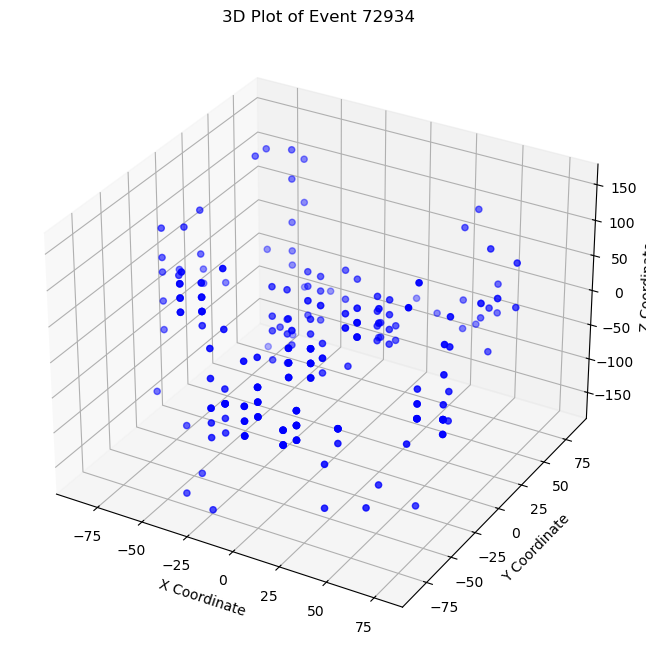

In [7]:
import matplotlib
#matplotlib.use('Qt5Agg')
hit_number = ((signal_data != -1).all(axis = -1)).sum(axis=-1)

event_index = np.argmax(hit_number)  # Index of the event to plot
event_location = signal_data_location[event_index]

# Filter out padding values
valid_mask = ~(event_location == -1).any(axis=-1)
event_location = event_location[valid_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(event_location[:, 0], event_location[:, 1], event_location[:, 2], c='b', marker='o')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title(f'3D Plot of Event {event_index}')

plt.show()

In [8]:
class LearnedSeedVectors(keras.Model):
    def __init__(self, num_seeds, seed_dim):
        super(LearnedSeedVectors, self).__init__()
        self.seeds = tf.Variable(tf.random.normal([num_seeds, seed_dim]), trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Repeat the seeds for each batch element
        seeds = tf.repeat(self.seeds[tf.newaxis, :, :], batch_size, axis=0)
        return seeds

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seeds.shape[0], self.seeds.shape[1])


class GenerateMask(keras.Model):
    def __init__(self, padding_value = -1):
        super(GenerateMask, self).__init__()
        self.padding_value = padding_value

    def call(self, inputs):
        mask = tf.not_equal(inputs, self.padding_value)
        return tf.reduce_any(mask, axis=-1, keepdims=True)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (input_shape[-1],)

class ScaleLayer(keras.layers.Layer):
    def __init__(self, data, range = (0, 1)):
        super(ScaleLayer, self).__init__()
        self.scale = (range[1] - range[0]) / (np.max(data) - np.min(data))

    def call(self, inputs, inverted=False):
        if inverted:
            return inputs / self.scale
        else:
            return inputs * self.scale

    def compute_output_shape(self, input_shape):
        return input_shape

class MaskOutput(keras.layers.Layer):
    def __init__(self, padding_value=-1):
        super(MaskOutput, self).__init__()
        self.padding_value = padding_value

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = tf.cast(mask, inputs.dtype)
            
            inputs = inputs * mask
            inputs = inputs + (1 - mask) * self.padding_value
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
input = keras.Input(shape=(256,3), dtype=tf.int32, name="input")
latent_dim = 8
# Build encoder
mask = GenerateMask(padding_value=-1)(input)
flatted_mask = keras.layers.Flatten()(mask)
input_embedding = keras.layers.Dense(8, activation='relu')(input)

multi_head = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8)(input_embedding, input_embedding, attention_mask=mask)
normalised_residual = keras.layers.LayerNormalization()(multi_head + input_embedding)
dense_layer = keras.layers.Dense(8, activation='relu')(normalised_residual)
transformer_output = keras.layers.LayerNormalization()(dense_layer + normalised_residual)
seed_vectors = LearnedSeedVectors(num_seeds=10, seed_dim=8)(transformer_output)

ff_transformer_output = keras.layers.Dense(8, activation='relu')(transformer_output)

fixed_size_output = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8)(seed_vectors, ff_transformer_output,ff_transformer_output, value_mask=flatted_mask)
# Build symmetric decoder
latent_output = keras.layers.Dense(latent_dim, activation='relu')(fixed_size_output)

decoder_seed_vectors = keras.layers.Dense(8, activation='relu')(latent_output)
decoder_sequence_vectors = LearnedSeedVectors(num_seeds=256, seed_dim=8)(decoder_seed_vectors)
decoder_output = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8)(decoder_sequence_vectors, decoder_seed_vectors, decoder_seed_vectors, attention_mask=mask)
decoder_ff_transformer_output = keras.layers.Dense(8, activation='relu')(decoder_output)
decoder_multi_head = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8)(decoder_ff_transformer_output, decoder_ff_transformer_output, attention_mask=mask)
decoder_normalised_residual = keras.layers.LayerNormalization()(decoder_multi_head + decoder_ff_transformer_output)
decoder_dense_layer = keras.layers.Dense(8, activation='relu')(decoder_normalised_residual)
decoder_transformer_output = keras.layers.LayerNormalization()(decoder_dense_layer + decoder_normalised_residual)
decoder_sigmoid = keras.layers.Dense(3, activation='sigmoid')(decoder_transformer_output)
decoder_output = keras.layers.Reshape((256,3))(decoder_sigmoid)
masked_output = MaskOutput(padding_value=-1)(decoder_output, mask=mask)



2025-07-18 12:01:47.667355: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-18 12:01:47.667396: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-18 12:01:47.667410: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-18 12:01:47.667442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-18 12:01:47.667451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
autoencoder = keras.Model(inputs=input, outputs=masked_output)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 3)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 8)    │         32 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generate_mask       │ (None, 256, 3)    │          0 │ input[0][0]       │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 8)    │      1,128 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0],      │
│                     │                   │            │ generate_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 8)    │          0 │ multi_head_atten… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 8)    │         16 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 8)    │         72 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 8)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 8)    │         16 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ learned_seed_vecto… │ (None, 10, 8)     │          0 │ layer_normalizat… │
│ (LearnedSeedVector… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 8)    │         72 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ generate_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 8)     │      1,128 │ learned_seed_vec… │
│ (MultiHeadAttentio… │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_2[0][0],    │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 8)     │         72 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 8)     │         72 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ learned_seed_vecto… │ (None, 256, 8)    │          0 │ dense_4[0][0]     │
│ (LearnedSeedVector… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 8)    │      1,128 │ learned_seed_vec… │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_4[0][0],    │
│                     │                   │            │ generate_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,067 (19.79 KB)

 Trainable params: 5,067 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
autoencoder.fit(background_data_location, background_data_location, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


2025-07-18 12:01:49.800512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2501/2501 ━━━━━━━━━━━━━━━━━━━━ 366s 143ms/step - loss: 527.5015 - val_loss: 524.3513
Epoch 2/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 384s 154ms/step - loss: 524.2113 - val_loss: 525.3339
Epoch 3/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 346s 138ms/step - loss: 528.9059 - val_loss: 525.4631
Epoch 4/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 348s 139ms/step - loss: 527.5263 - val_loss: 525.4276
Epoch 5/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 350s 140ms/step - loss: 526.5751 - val_loss: 525.4170
Epoch 6/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 356s 142ms/step - loss: 528.0357 - val_loss: 525.3263
Epoch 7/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 380s 152ms/step - loss: 526.7213 - val_loss: 525.4052
Epoch 8/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 383s 153ms/step - loss: 525.2322 - val_loss: 525.4037
Epoch 9/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 385s 154ms/step - loss: 524.7702 - val_loss: 525.3363
Epoch 10/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 386s 154ms/step - loss: 525.8299 - val_loss: 525.3363


In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]